# Question: How hot will my drink be by the time I get to work based on which the temperature outside and the amount of liquid in my thermos?
Material: state is liquid system includes conductivity constant of the thermos material, area of contact between conductor and water, thickness of thermos, mass of water, and the conductivity constant of water.

Abstract: This model answers the question above. In doing so, I can decide what conditions are best for keeping my drink warm depending on the situation. The model finds that in general, the amount of liquid in the thermos has the largest effect on the final temperature, while the outside temperature has almost no effect. To get keep your drink the hottest by the time you get to work, fill the thermos to the point where there will be a slight air gap between the liquid and the lid. The gap of air will lower the efficiency of heat transfer, but still maximize mass of the drink.

In [1]:
# import functions from the modsim.py module

from modsim import *

import math

In [2]:
def make_system(k, A, d, c, m, e, temp, dt):
    """Make a system object for a conductor
    
    k: thermal conductivity
    A: cross sectional area
    d: thickness
    c: specific heat
    m: mass of substance absorbing heat (g)
    e: efficiency of heat transfer
    temp: temperature outside
    dt: time step
    
    returns: System object
    """
    init = State(liquid=373.15)

    t0 = 0
    t_end = 1000

    return System(init=init, t0=t0, t_end=t_end,
                  k=k, A=A, d=d, c=c, m=m, e=e, 
                  temp=temp, dt=dt)

In [3]:
k_plastic=.2
A=.05
d=.05
c=4.816
m=500
e=.8
temp=295
dt=10
sys = make_system(k_plastic, A, d, c, m, e, temp, dt)

In [4]:
def plot_results(system, liquid):
    """Plot the results of thermal conductivity model
    
    sugar: TimeSeries
    """
    print("TIME STEP: ", system.dt, "s")
    plot(liquid, '--', label='liquid')
    
    decorate(xlabel=("Time (minutes)"),
             ylabel=("Temperature (K)"),
             title=("Heating Curve of Liquid in Thermos"))

In [5]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(t0, t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

## Euler's Method

In [6]:
def update_func(state, t, system):
    """Update thermal conductivity model
    
    state: State (liquid)
    t: time
    system: System object
    
    returns: State (liquid)
    """
    l = state.liquid
    unpack(system)
    
    dT_conductor = temp - l
    
    dT_liquid = ((k*A*dT_conductor*dt)/(d*m*c))*e
    
    l+=dT_liquid
    
    return State(liquid = l)

In [7]:
results = run_simulation(sys, update_func)

TIME STEP:  10 s


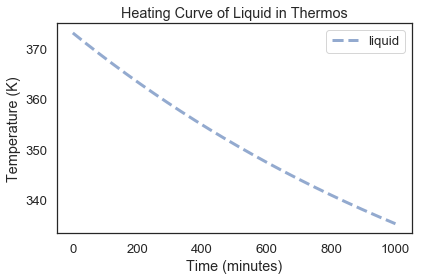

In [8]:
plot_results(sys,results.liquid)

Euler's method works as planned and does not behave unexpectedly. Though it works, it takes a large amount of time to get a significant range of data, making sweeping slow. The graph displays the temperature of the drink over time when the outside temperature is 22 degrees Celcius.

## ODE Solver

In [9]:
def slope_func(state, t, system):
    """Update thermal conductivity model
    
    state: State (liquid)
    t: time
    system: System object
    
    returns: State (liquid)
    """
    
    unpack(system)
    
    l = state
    outside = 295.15
    
    dT_conductor = outside - l
    
    dt = 10
    
    dT_liquid = ((k*A*dT_conductor*dt)/(d*m*c))*e
    
    return State(dT_liquid=dT_liquid)

In [10]:
results, details = run_ode_solver(sys, slope_func)
details

,values
sol,None
t_events,[]
nfev,32
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


TIME STEP:  10 s


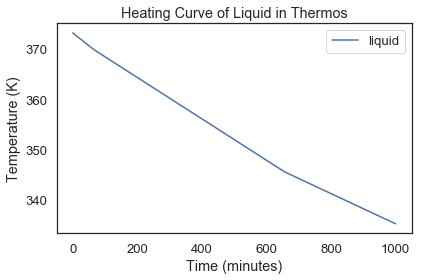

In [11]:
results.plot()

print("TIME STEP: ", sys.dt, "s")
decorate(xlabel=("Time (minutes)"),
             ylabel=("Temperature (K)"),
             title=("Heating Curve of Liquid in Thermos"))

In [12]:
results, details = run_ode_solver(sys, slope_func, max_step=10)
details

,values
sol,None
t_events,[]
nfev,614
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


TIME STEP:  10 s


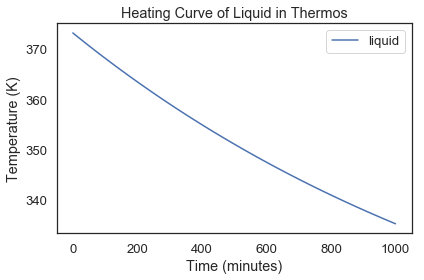

In [13]:
results.plot()
print("TIME STEP: ", sys.dt, "s")
decorate(xlabel=("Time (minutes)"),
             ylabel=("Temperature (K)"),
             title=("Heating Curve of Liquid in Thermos"))

The ODE solver does all that it needs to, and does so more efficiently than Euler's method. The graph displays the temperature of the drink over time when the outside temperature is 22 degrees Celcius.

## Sweeping Parameters

In [14]:
def temp_at(time, results):
    """Find the temperature at time (time)
    
    time: time in results
    results: timeseries
    
    returns: integer value of temperature at that time
    """
    return results.row[time]

In [15]:
def sweep_e(k, A, d, c, m, e_array, temp, dt, time, update_func):
    """Sweep a range of values for efficiency.
    
    k: thermal conductivity
    A: cross sectional area
    d: thickness
    c: specific heat
    m: mass of substance absorbing heat
    e_array: array of efficiency of heat transfer
    temp: temperature outside
    dt: time step
    time: temp at time
    update_func: update function
    
    returns: SweepSeries that maps from efficiency to temperature
    """
    sweep = SweepSeries()
    for e in e_array:
        system = make_system(k, A, d, c, m, e, temp, dt)
        results, details = run_ode_solver(system, update_func, max_step=10)
        sweep[system.e] = temp_at(time, results)
    return sweep

In [16]:
e_array = linspace(0.1, 1, 10)
efficiency = sweep_e(.2, .05, .05, 4.816, 500, e_array, 295, 10, 1000, slope_func)

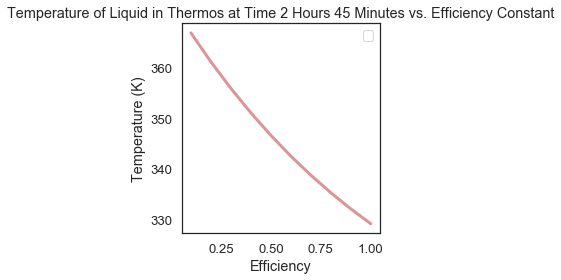

In [17]:
plot(efficiency, 'r')

decorate(xlabel=("Efficiency"),
             ylabel=("Temperature (K)"),
             title=("Temperature of Liquid in Thermos at Time 2 Hours 45 Minutes vs. Efficiency Constant"))

Sweeping the efficiency value allows for validation of the model against a real world test. As the efficiency of heat transfer increases, the temperature of the liquid at about 2 hours and 45 minutes. If the efficiency of heat transfer can be minimized, the drink will stay hotter longer, and to do so, one might want to leave some room for air in the thermos.

In [18]:
def sweep_m(k, A, d, c, m_array, e, temp, dt, time, update_func):
    """Sweep a range of values for mass.
    
    k: thermal conductivity
    A: cross sectional area
    d: thickness
    c: specific heat
    m: mass of substance absorbing heat
    e_array: array of efficiency of heat transfer
    temp: temperature outside
    dt: time step
    time: temp at time
    update_func: update function
    
    returns: SweepSeries that maps from liquid's mass to temperature
    """
    sweep = SweepSeries()
    for m in m_array:
        system = make_system(k, A, d, c, m, e, temp, dt)
        results, details = run_ode_solver(system, update_func, max_step=10)
        sweep[system.m] = temp_at(time, results)
    return sweep

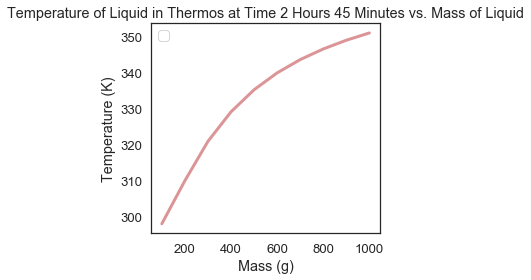

In [19]:
m_array = linspace(100, 1000, 10)
mass = sweep_m(.2, .05, .05, 4.816, m_array, .8, 295, 10, 1000, slope_func)
plot(mass, 'r')

decorate(xlabel=("Mass (g)"),
             ylabel=("Temperature (K)"),
             title=("Temperature of Liquid in Thermos at Time 2 Hours 45 Minutes vs. Mass of Liquid"))

Sweeping the mass value demonstrates that more liquid in the container results in a greater temperature after 2 hours and 45 minutes. Thus, having more of a given drink in a thermos will better preserve the temperature of the drink

In [20]:
def sweep_temp(k, A, d, c, m, e, temp_array, dt, time, update_func):
    """Sweep a range of values for outside temperature.
    
    k: thermal conductivity
    A: cross sectional area
    d: thickness
    c: specific heat
    m: mass of substance absorbing heat
    e_array: array of efficiency of heat transfer
    temp: temperature outside
    dt: time step
    time: temp at time
    update_func: update function
    
    returns: SweepSeries that maps from liquid's temperature to outside temperature
    """
    sweep = SweepSeries()
    for temp in temp_array:
        system = make_system(k, A, d, c, m, e, temp, dt)
        results, details = run_ode_solver(system, update_func, max_step=10)
        sweep[system.temp] = temp_at(time, results)
    return sweep

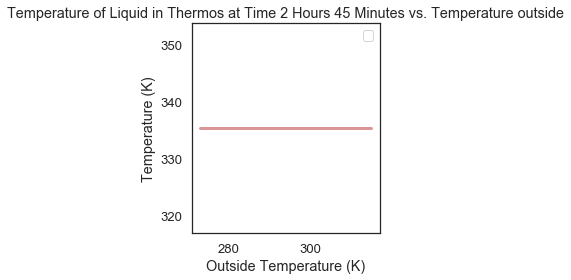

In [21]:
temp_array = linspace(273, 315, 10)
temperature = sweep_temp(.2, .05, .05, 4.816, 500, .8, temp_array, 10, 1000, slope_func)
plot(temperature, 'r')

decorate(xlabel=("Outside Temperature (K)"),
             ylabel=("Temperature (K)"),
             title=("Temperature of Liquid in Thermos at Time 2 Hours 45 Minutes vs. Temperature outside"))

Sweeping a range of outside temperatures reveals that the outside temperature has no effect on the temperature of the drink after 2 hours and 45 minutes.

## Interpretations
My drink will be the hottest if the efficiency of heat transfer between the lid and the liquid can be minimized, while still having as much liquid in the thermos as possible. Knowing this, I can keep my drink as warm as possible by the time I get to work.

## Verification

We put boiling water into a Hydroflask brand thermos and measured its temperature to be 370 degrees Kelvin. We closed the thermos and left it in a cool, dry place inside, with a room temperature of about 295.15 degrees Kelvin. After 8 hours, the water inside the thermos measured 346.15 degrees Kelvin. With our measurements, there is a 23.85 degree change in temperature after 8 hours, or 480 minutes, which is similar to what we predicted with our model. 